# 0.1.1 Combigen All-True Bug Fix

While working on nb 0.2 I spotted a corner case for the task that would make it impossible to classify, which is the situation where one of the columns in the label is completely on. 

Rather than having this be part of that nb, I've split it off since it doesn't fit the theme of that analysis.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn

Sun Feb 17 2019 17:49:44 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 6e55d381ad16a202628f8b3e5bc3d38c6e4f9693
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cbg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cbhm
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## The Combigen Task as it Stands

Just to remind ourselves what the task looks like. For more detail, check out nb-0.1.

The bug was discovered when the implementation of generate labels was the following:

In [8]:
def generate_labels(n_samples=1, size=5, dims=2):
    """..."""
    return np.random.choice(2, (n_samples, size, dims), True)

Let's visualize a few `y` and `x` combinations: 

2019-02-17 17:50:22 apra-xps13 leabratf.utils[7354] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.
2019-02-17 17:50:22 apra-xps13 leabratf.utils[7354] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.


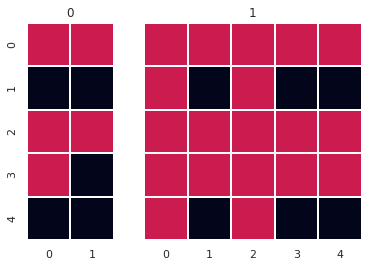

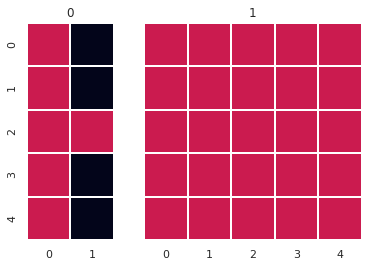

In [21]:
def visualize_combigen(func=generate_labels, n_pairs=2, *args, **kwargs):
    """Plot N x and y pairs of the combigen task"""
    # Visulize a few combinations of x and y
    for _ in range(n_pairs):
        # Generate a signle y
        example_y = func( *args, **kwargs) # cbg.generate_labels for the real thing
        # Generate a single x from the y
        example_x = cbg.inverse_transform(example_y)
        cbhm.heatmap([example_y, example_x[0]], gridspec_kw={'width_ratios': [2, 5]}, sharex=False)
        
visualize_combigen()
plt.show()

It took several tries but the second image demonstrates the bug relatively well. We can make this observation more concrete:

In [22]:
def test_all_label_counts(func=generate_labels, n_labels=1000000, *args, **kwargs):
    """Genrates `n_labels` labels and checks their sums."""
    # Generate a large number of y values to test
    large_test_Y = func(n_labels,  *args, **kwargs)
    
    # Sum over the long dimension of each sample to see how many of them are set to
    # the on state. If they are all on, then it will sum to the length of the dim.
    label_sums = np.sum(large_test_Y, axis=1)
    values_in_sum = np.isin(range(large_test_Y.shape[1] + 1), label_sums)
    
    # Get unique values in the sum and their counts and put them in a dict
    count_dict = {val:count for val, count in zip(
        *np.unique(label_sums, return_counts=True))}
    # Sanity check
    assert sum(count_dict.values()) == n_labels * large_test_Y.shape[2]
    
    # We should see that all values up to the last one are set to True
    print('Checking sums.')
    for i, present in enumerate(values_in_sum):
        print('"{0}" present in sum: {1}. Counts: {2}'.format(
            i, present , count_dict.get(i) or 0))
    
# Test run the function
test_all_label_counts()

Checking sums.
"0" present in sum: True. Counts: 62832
"1" present in sum: True. Counts: 312998
"2" present in sum: True. Counts: 624089
"3" present in sum: True. Counts: 625160
"4" present in sum: True. Counts: 312635
"5" present in sum: True. Counts: 62286


Turns out it's getting roughly the same number of all `True` as all `False`, which isn't surprising but definitely makes the scope of the problem clear.

## All-True Fix

It is currently defined as the following:

```
def generate_labels(n_samples=1, size=5, dims=2):
    """..."""
    return np.random.choice(2, (n_samples, size, dims), True)
```

So let's tweak it so it ensures that one of the indices are zero.

In [23]:
def generate_labels_fix(n_samples=1, size=5, dims=2):
    """Returns an array of labels to construct the data from.

    Parameters
    ----------
    n_samples : int, optional
        Number of samples to return.

    size : int, optional
        Size of the nxn matrix to use for the task.

    dims : int, optional
        Number of dimensions for the task.

    Returns
    -------
    labels : np.ndarray (n_samples x size x dims)
    	The resulting task labels.
    """
    # Generate baseline labels
    raw_labels = np.random.choice(2, (n_samples, size, dims), replace=True)
    # Random selection of indices to zero out
    arg_zero = np.random.choice(size, (n_samples*dims), replace=True)
    # Alternating indices to loop through the dims of the labels
    dim_indices = np.tile(range(dims), n_samples)
    # Repeating indices to loop through the samples
    sample_indices = np.repeat(range(n_samples), dims)
    
    # Zero out a random selection of indices
    raw_labels[sample_indices, arg_zero, dim_indices] = 0
    return raw_labels

Let's see if we did any better with the count tester.

In [24]:
# Test run the function
test_all_label_counts(generate_labels_fix)

Checking sums.
"0" present in sum: True. Counts: 125119
"1" present in sum: True. Counts: 499889
"2" present in sum: True. Counts: 749990
"3" present in sum: True. Counts: 500380
"4" present in sum: True. Counts: 124622
"5" present in sum: False. Counts: 0


Much better.